In [1]:
import csv
import time

def read(filename, data_idx, data_parse, year, bucket=7):
    days_in_year = 365
    
    freq = {}
    for period in range(0, int(days_in_year / bucket)):
        freq[period] = 0
    
    with open(filename, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        next(csvreader, None)
        for row in csvreader:
            if len(row[data_idx]) > 0:
                t = time.strptime(row[data_idx], data_parse)
                if t.tm_year == year and t.tm_yday < (days_in_year-1):
                    freq[int(t.tm_yday / bucket)] += 1
    
    return freq

In [2]:
freq = read('311_Call_Center_Tracking_Data__Archived_.csv', 0, '%m/%d/%Y', 2014)

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def split_dataset(x_dataset, y_dataset, ratio):
    arr = np.arange(x_dataset.size)
    np.random.shuffle(arr)
    num_train = ratio * x_dataset.size
    x_train = x_dataset[arr[0:num_train]]
    y_train = y_dataset[arr[0:num_train]]
    x_test = x_dataset[arr[num_train:x_dataset.size]]
    y_test = y_dataset[arr[num_train:x_dataset.size]]
    return x_train, x_test, y_train, y_test

In [82]:
num_coeffs = 2 # somehow higher coefficient order does not work
learning_rate = 0.001
training_epochs = 1000
reg_lambda = 10.0

In [83]:
(x_dataset, y_dataset) = zip(*freq.items())

x_dataset = np.fromiter(iter(x_dataset), dtype=int)
y_dataset = np.fromiter(iter(y_dataset), dtype=int)
print(x_dataset)
print(y_dataset)

(x_train, x_test, y_train, y_test) = split_dataset(x_dataset, y_dataset, 0.7)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51]
[10278 16752 15023 16961 16568 16276 14739 17424 17247 16508 17192 17296
 17073 18252 17658 16604 17604 18274 17708 19276 15542 19434 17733 17580
 18232 18809 15896 18436 19021 19186 18396 17901 19212 18941 16145 19536
 18135 17970 17595 18952 17257 18368 18252 18246 18069 17623 18332 12117
 17130 18217 17510 11972]


/Users/yusuke/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/yusuke/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/yusuke/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/yusuke/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


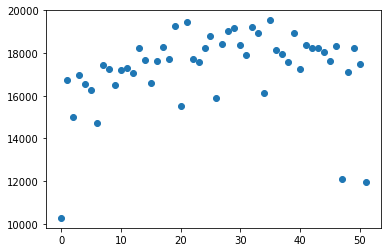

In [55]:
plt.scatter(x_dataset, y_dataset)
plt.show()

In [60]:
X = tf.placeholder("float")
Y = tf.placeholder("float")

In [84]:
def model(X, w):
    terms = []
    for i in range(num_coeffs):
        term = tf.multiply(w[i], tf.pow(X, i))
        terms.append(term)
    return tf.add_n(terms)

In [85]:
w = tf.Variable([0.] * num_coeffs, name="parameters")
y_model = model(X, w)
cost = tf.div(
    tf.add(
        tf.reduce_sum(tf.square(Y-y_model)),
        tf.multiply(reg_lambda, tf.reduce_sum(tf.square(w)))
    ),
    2*x_train.size
)
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [87]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [88]:
for reg_lambda in np.linspace(0,10,100):
    for epoch in range(training_epochs):
        sess.run(train_op, feed_dict={X: x_train, Y: y_train})
    final_cost = sess.run(cost, feed_dict={X: x_test, Y: y_test})
    print('reg lambda', reg_lambda)
    print('final cost', final_cost)

reg lambda 0.0
final cost 1.12874e+07
reg lambda 0.10101010101
final cost 1.14344e+07
reg lambda 0.20202020202
final cost 1.22038e+07
reg lambda 0.30303030303
final cost 1.28684e+07
reg lambda 0.40404040404
final cost 1.33222e+07
reg lambda 0.505050505051
final cost 1.36058e+07
reg lambda 0.606060606061
final cost 1.3776e+07
reg lambda 0.707070707071
final cost 1.3876e+07
reg lambda 0.808080808081
final cost 1.3934e+07
reg lambda 0.909090909091
final cost 1.39675e+07
reg lambda 1.0101010101
final cost 1.39868e+07
reg lambda 1.11111111111
final cost 1.39978e+07
reg lambda 1.21212121212
final cost 1.40041e+07
reg lambda 1.31313131313
final cost 1.40077e+07
reg lambda 1.41414141414
final cost 1.40097e+07
reg lambda 1.51515151515
final cost 1.40111e+07
reg lambda 1.61616161616
final cost 1.40114e+07
reg lambda 1.71717171717
final cost 1.40114e+07
reg lambda 1.81818181818
final cost 1.40114e+07
reg lambda 1.91919191919
final cost 1.40114e+07
reg lambda 2.0202020202
final cost 1.40114e+07
re

In [89]:
w_val = sess.run(w)
print(w_val)

[ 8290.63476562   281.33163452]


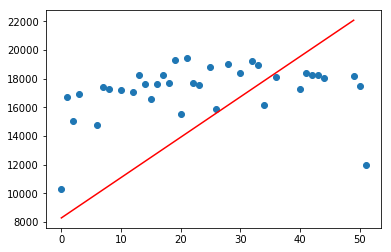

In [90]:
trX = range(0, 50)
plt.scatter(x_train, y_train)
trY = 0
for i in range(num_coeffs):
    trY += w_val[i] * np.power(trX, i)
plt.plot(trX, trY, 'r')
plt.show()